# Motor Learning with Gazebo and Deep Neural Networks

## Generate Robot Arm Simulation Data

1. Build the robot arm model consisting of a fixed base and 3 arm segments connected by 1-dimensional revolute joints, apply friction angular limits to each joint.
2. Setup the robot operating system model to interface gazebo with python.
3. Generate joint effort matrices:

In [1]:
# This is the core of the python controller
# It requires ROS and gazebo to be properly configured

# rospy.init_node('armcontroller')
# rate = rospy.Rate(50)
# for run in range(1000, 5000):
#     rospy.loginfo('Run {}'.format(run))
#     reset_sim()
#     joint_efforts = 100 * (numpy.random.rand(250, 3) - 0.5)
#     joint_efforts = savgol_filter(joint_efforts, 31, 3, axis=0)
#     hand_positions = numpy.zeros((250, 2))
#     row = 0
#     while not rospy.is_shutdown() and row < 250:
#         apply_effort('ShoulderJoint', joint_efforts[row,0])
#         apply_effort('ElbowJoint', joint_efforts[row,1])
#         apply_effort('WristJoint', joint_efforts[row,2])
#         pos = get_hand_position()
#         hand_positions[row,0] = pos.x
#         hand_positions[row,1] = pos.z
#         row += 1
#         rate.sleep()
#     numpy.save('/home/tim/data/joints{}'.format(run), joint_efforts)
#     numpy.save('/home/tim/data/hand{}'.format(run), hand_positions)

Below is a recording of the gazebo simulation running with the arm controller. In between each 5s run, the simulation is reset to the starting position.

<img src="GazeboSim.gif">

## Load Data
Data from the robot simulation are stored in two files per run. The joints#.npy files each contain a 250x3 matrix. Each row reflects the effort (~torque) applied to the joints for 20ms. The hand#.npy files each contain a 250x2 matrix. The rows in these files are observations of the cartesian x and z coordinates of the hand.

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
alljoints = numpy.load('joints.npy')
allhands = numpy.load('hands.npy')

## Visualize Data
Joint efforts (shoulder, elbow, and wrist) are savitsky-golay smoothed white noise. There probably isn't much to see in the raw data, but it's always a good starting point.

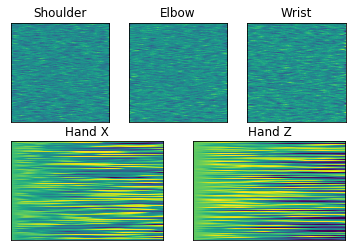

In [4]:
def auto_show_img(image, subplot, label):
    pyplot.subplot(subplot)
    pyplot.imshow(image, aspect='auto', interpolation='nearest', )
    pyplot.title(label)
    pyplot.xticks([])
    pyplot.yticks([])

pyplot.figure()
auto_show_img(alljoints[:,:250], 231, 'Shoulder')
auto_show_img(alljoints[:,250:500], 232, 'Elbow')
auto_show_img(alljoints[:,500:], 233, 'Wrist')
auto_show_img(allhands[:,:250], 223, 'Hand X')
auto_show_img(allhands[:,250:], 224, 'Hand Z')

In [5]:
numpy.save('joints.npy', alljoints)
numpy.save('hands.npy', allhands)

Trajectories might give a bit more insight. On the left are the first 5 trajectories, illustrating the nested circular paths characteristic of the 3-joint arm. On the right is a 2-dimensional histogram (a density plot) for all 5000 trajectories. Occupancy of the reachable space is somewhat biased towards the starting point and the edges.

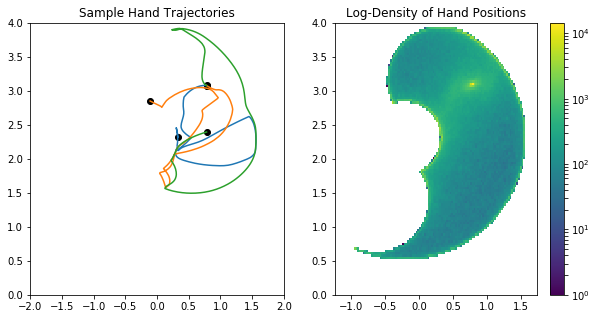

In [6]:
pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
i = numpy.random.randint(0, 5000, (3))
pyplot.plot(allhands[i,:250].transpose(), allhands[i,250:].transpose())
pyplot.scatter(allhands[i,0].transpose(), allhands[i,250].transpose(), color='k')
pyplot.scatter(allhands[i,249].transpose(), allhands[i,499].transpose(), color='k')
pyplot.title('Sample Hand Trajectories')
pyplot.xlim(-2, 2)
pyplot.ylim(0, 4)

pyplot.subplot(122)
allx = allhands[:,:250].reshape((-1))
ally = allhands[:,250:].reshape((-1))
from matplotlib.colors import LogNorm
pyplot.hist2d(allx, ally, bins=100, norm=LogNorm())
pyplot.title('Log-Density of Hand Positions')
pyplot.xlim(-1.25, 1.75)
pyplot.ylim(0, 4)
pyplot.colorbar()

Finally, we can use cross-correlation to try and visualize linear effects of joint effort on hand position. We know that the true effects should be nonlinear, but over small windows of time and space, we might still see a linear relationship.

Below we calculate the lagged correlation coefficients of each trajectory for each joint on the stepwise difference in each component of the position.

In [8]:
def lagged_corrcoef(a, b, maxlag):
    coefs = numpy.zeros((a.shape[0],maxlag))
    for i in range(a.shape[0]):
        for lag in range(maxlag):
            coefs[i,lag] = numpy.corrcoef(a[i,:b.shape[1]-lag], b[i,lag:])[1,0]
    return coefs

# Using more rows to calculate the correlations takes longer
rows = numpy.random.permutation(alljoints.shape[0])[:500]
dx = numpy.diff(allhands[:,:250], axis=1)
dy = numpy.diff(allhands[:,250:], axis=1)
ax = lagged_corrcoef(alljoints[rows,:250], dx[rows,:], 248)
ay = lagged_corrcoef(alljoints[rows,:250], dy[rows,:], 248)
bx = lagged_corrcoef(alljoints[rows,250:500], dx[rows,:], 248)
by = lagged_corrcoef(alljoints[rows,250:500], dy[rows,:], 248)
cx = lagged_corrcoef(alljoints[rows,500:], dx[rows,:], 248)
cy = lagged_corrcoef(alljoints[rows,500:], dy[rows,:], 248)

Next we can average the correlation coefficients across rows and then plot those to see the effect in time of a nudge to any of the joints. For long lags, there are fewer points to calculate the correlation, so the values will be noisier.

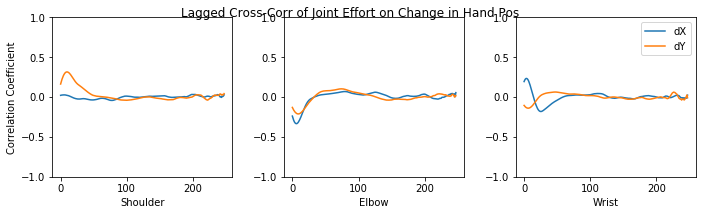

In [9]:
pyplot.figure(figsize=(10,3))
pyplot.suptitle('Lagged Cross-Corr of Joint Effort on Change in Hand Pos')
pyplot.subplot(131)
pyplot.plot(ax.mean(axis=0))
pyplot.plot(ay.mean(axis=0))
pyplot.xlabel('Shoulder')
pyplot.ylabel('Correlation Coefficient')
pyplot.ylim(-1,1)
pyplot.subplot(132)
pyplot.plot(bx.mean(axis=0))
pyplot.plot(by.mean(axis=0))
pyplot.xlabel('Elbow')
pyplot.ylim(-1,1)
pyplot.subplot(133)
pyplot.plot(cx.mean(axis=0), label='dX')
pyplot.plot(cy.mean(axis=0), label='dY')
pyplot.xlabel('Wrist')
pyplot.ylim(-1,1)
pyplot.legend()
pyplot.tight_layout()

Clearly, none of the joints has a very strong linear effect on the position of the hand, but there is some indication of the underlying dynamics. The very slow effects (greater than 1s) are probably due to autocorrelation in the joint efforts.

## Learning the Motor Transfer Function

Now that the data are loaded and we have completed preliminary exploration, we can try to learn the transfer function for joint efforts to hand positions.

In principle, this should be something like the following:

***a<sub>i</sub> ( t )*** is joint angle for joint ***i*** at time ***t***

***j<sub>i</sub> ( t )*** is joint effort for joint ***i*** at time ***t***

***f ( j )*** is friction, if ***| j | < k***, then ***f ( j ) = j***, else ***f ( j ) = k * sign ( j )***, where ***k*** is constant

***da<sub>i</sub> ( t ) = ( j<sub>i</sub> ( t ) - f ( j<sub>i</sub> ( t ) ) ) / m<sub>i</sub>***, where ***m<sub>i</sub>*** scales for the mass connected to joint ***i***

***a<sub>i</sub> ( t ) = a<sub>i</sub> ( t - 1 ) + da<sub>i</sub> ( t ) = sum<sub>0:t</sub> [ da<sub>i</sub> ( . ) ] + a<sub>i</sub> ( 0 )***

***l<sub>i</sub>*** is length of segment ***i***, ***c<sub>x</sub>*** and ***c<sub>y</sub>*** are the constant offsets for ***x*** and ***y***

***x ( t ) = l<sub>1</sub> cos ( a ( 1 , t ) ) + l<sub>2</sub> cos ( a ( 1 , t ) + a ( 2 , t ) ) + l<sub>3</sub> cos ( a ( 1 , t ) + a ( 2 , t ) + a ( 3 , t ) ) + c<sub>x</sub>***

***y ( t ) = l<sub>1</sub> sin ( a ( 1 , t ) ) + l<sub>2</sub> sin ( a ( 1 , t ) + a ( 2 , t ) ) + l<sub>3</sub> sin ( a ( 1 , t ) + a ( 2 , t ) + a ( 3 , t ) ) + c<sub>y</sub>***

That's not quite right for a couple of reasons: **(a)** the simulation we used to generate the data is based on iterated differential equations with much greater temporal precision than the 10ms steps of our input/output, **(b)** the radial inertia ***m<sub>i</sub>*** is itself a complex nonlinear function of the joint angles, and **(c)** the joint angles are bounded, which means ***da<sub>i</sub> ( t )*** has a nonlinear dependence on ***a<sub>i</sub> ( t - 1 )***. Nevertheless, the above transfer function should be approximately correct over small movements.

In [69]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    numpy.random.seed(seed)

## Simple Model: Dense1 (250 ReLU)

In [75]:
reset_graph()
n_inputs = 3 * 250 # Joints * Samples
n_dense1 = 250
n_outputs = 2 * 250 # Dimensions * Samples

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
Y = tf.placeholder(tf.float32, shape=(None), name='Y')

drop_rate = tf.placeholder_with_default(0.0, shape=(), name='drop_rate')

with tf.name_scope('dnn'):
    vsi_init = tf.contrib.layers.variance_scaling_initializer()
    drop_x = tf.layers.dropout(X, drop_rate)
    dense1 = tf.layers.dense(drop_x, n_dense1, activation=tf.nn.relu,
                             kernel_initializer=vsi_init, name='dense1')
    drop1 = tf.layers.dropout(dense1, drop_rate)
    outputs = tf.layers.dense(drop1, n_outputs, name='outputs')

The network is trained by minimizing the mean squared error of the predicted hand trajectories using gradient descent and an annealed learning rate.

80% of the simulation data is assigned to the training set. Input data are scaled to have mean 0 and variance 1. For each epoch, training data are randomly assigned to batches before invoking the training operation. After training, the train and test error are evaluated on the full datasets. Finally, after training completes, predictions are generated for each row of the test dataset.

In [101]:
# Setup the train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(alljoints, allhands, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [100]:
# Define the loss function, optimizer, and training regime
def train_model(inputs, outputs, targets, n_epochs=100, batch_size=10, initial_lr=0.05):
    with tf.name_scope('loss'):
        mse = tf.losses.mean_squared_error(targets, outputs)
        loss = tf.reduce_mean(mse, name='loss')
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(initial_lr, batch * batch_size,
                                               X_train.shape[0], 0.99)
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss, global_step=batch)
    epoch_mse = numpy.zeros((n_epochs, 2))
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            shuffled_indices = numpy.random.permutation(X_train.shape[0])
            for b in range(X_train.shape[0] // batch_size):
                batch = shuffled_indices[b * batch_size:(b + 1) * batch_size]
                X_batch = X_train[batch,:]
                Y_batch = Y_train[batch,:]
                sess.run(training_op, feed_dict={drop_rate: 0.5, X: X_batch, Y: Y_batch})
            epoch_mse[epoch,0] = loss.eval(feed_dict={X: X_train, Y: Y_train})
            epoch_mse[epoch,1] = loss.eval(feed_dict={X: X_test, Y: Y_test})
            print '.',
        predictions = outputs.eval(feed_dict={X: X_test})
        return epoch_mse, predictions

dense1_mse, dense1_predictions = train_model(X, Y, outputs)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Plot the mean squared error of the train and test dataset for each training epoch.

Final Error: 0.125681787729


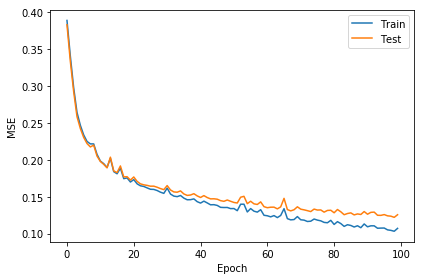

In [107]:
def plot_mse(mse):
    pyplot.figure()
    pyplot.plot(mse[:,0], label='Train')
    pyplot.plot(mse[:,1], label='Test')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('MSE')
    pyplot.legend()
    pyplot.tight_layout()

print('Final Error: {}'.format(dense1_mse[-1,1]))
plot_mse(dense1_mse)

Plot the predicted (**blue**) and actual (**orange**) trajectories for X (**top**) and Y (**bottom**) coordinates. Labels above each column correspond to row MSE, left are the best 3 predictions in the dataset and right are the best 3 predictions.

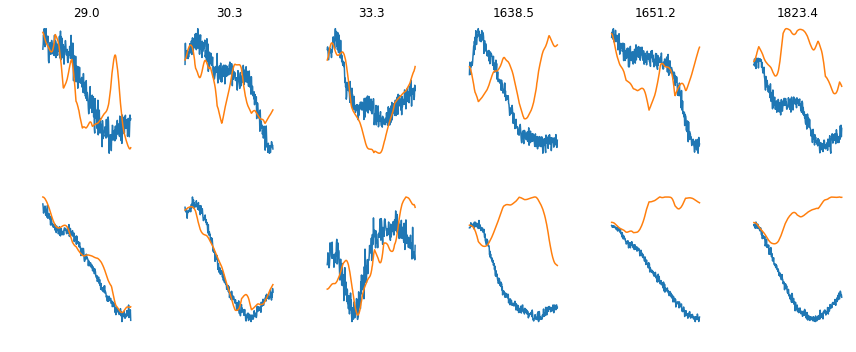

In [103]:
def plot_predictions(targets, predictions):
    row_mse = ((targets - predictions) ** 2).sum(axis=1)
    order = numpy.argsort(row_mse)
    best_and_worst = [0, 1, 2, 997, 998, 999]
    targets = targets[order,:][best_and_worst,:]
    predictions = predictions[order,:][best_and_worst,:]
    row_mse = row_mse[order][best_and_worst]
    pyplot.figure(figsize=(12,5))
    plot_num = 1
    for i in range(predictions.shape[0]):
        pyplot.subplot(2, 6, plot_num)
        pyplot.plot(predictions[i,:250])
        pyplot.plot(targets[i,:250])
        pyplot.title('{:.1f}'.format(row_mse[i]))
        pyplot.axis('off')
        plot_num += 1
    for i in range(predictions.shape[0]):
        pyplot.subplot(2, 6, plot_num)
        pyplot.plot(predictions[i,250:])
        pyplot.plot(targets[i,250:])
        pyplot.axis('off')
        plot_num += 1
    pyplot.tight_layout()

plot_predictions(Y_test, dense1_predictions)

While the best reconstructions demonstrate reasonably good fit overall, there is significant high frequency noise in the predictions. The worst reconstructions do not fit either the low frequency or high frequency movement.

## Complex Model: Conv2 (400 ReLU conv2d > 250 ReLU)

In [99]:
reset_graph()
n_joints = 3
n_samples = 250
n_inputs = n_joints * n_samples
n_c1filt = 16
c1_kernel = (3,50)
c1_stride = (3,2)
n_conv1 = 400
n_dense1 = 250
n_outputs = 2 * 250 # Dimensions * Samples

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
Y = tf.placeholder(tf.float32, shape=(None), name='Y')
drop_rate = tf.placeholder_with_default(0.0, shape=(), name='drop_rate')

with tf.name_scope('dnn'):
    vsi_init = tf.contrib.layers.variance_scaling_initializer()
    drop1 = tf.layers.dropout(X, drop_rate)
    reshape_x = tf.reshape(drop1, (-1, n_joints, n_samples, 1))
    conv1 = tf.layers.conv2d(reshape_x, filters=n_c1filt, kernel_size=c1_kernel,
                             strides=c1_stride, padding='SAME',
                             kernel_initializer=vsi_init, activation=tf.nn.relu)
    pool1 = tf.layers.average_pooling2d(conv1, pool_size=(1,5), strides=(1,5))
    conv1_flat = tf.reshape(pool1, (-1, n_conv1))
    drop2 = tf.layers.dropout(conv1_flat, drop_rate)
    dense1 = tf.layers.dense(drop2, n_dense1, activation=tf.nn.relu,
                             kernel_initializer=vsi_init, name='dense1')
    drop3 = tf.layers.dropout(dense1, drop_rate)
    outputs = tf.layers.dense(drop3, n_outputs, name='outputs')

In [ ]:
conv2_mse, conv2_predictions = train_model(X, Y, outputs)

In [105]:
print('Final Error: {}'.format(conv2_mse[-1,1]))
plot_mse(conv2_mse)

NameError: name 'conv2_mse' is not defined

In [ ]:
plot_predictions(Y_test, conv2_predictions)